In [0]:
# Databricks-ready PySpark code for dataset: ott_user_behavior_1
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

spark = SparkSession.builder.appName("OTT_Analytics").getOrCreate()

# ---------- 1) Load dataset (try Spark table, else CSV fallback) ----------
dataset_name = "ott_user_behavior_1"

try:
    df = spark.table(dataset_name)
    print(f"Loaded Spark table: {dataset_name}")
except Exception as e:
    print(f"Table {dataset_name} not found, trying CSV at /FileStore/tables/{dataset_name}.csv")
    df = spark.read.option("header", "true").option("inferSchema", "true") \
            .csv(f"/FileStore/tables/{dataset_name}.csv")

# quick clean / cast commonly-needed columns
# adjust column names if your schema differs (case-sensitive in Spark)
# Ensure numeric columns are numeric
num_cols = ["age", "avg_watch_time_per_day", "total_watch_time", "watch_duration",
            "completion_rate", "rating_given", "total_sessions_per_week",
            "avg_stream_quality", "network_speed_mbps", "buffering_count",
            "monthly_spend", "peak_watch_hour", "churn_flag"]
for c in num_cols:
    if c in df.columns:
        df = df.withColumn(c, col(c).cast(DoubleType()))

# Fill NA for numeric cols with 0 for safe model training (simple strategy)
numeric_present = [c for c in num_cols if c in df.columns]
df = df.fillna({c: 0.0 for c in numeric_present})

Loaded Spark table: ott_user_behavior_1


In [0]:
# ---------- Use Case 1: User Viewing Pattern Analysis ----------
# Avg daily watch time and total watch time by region and subscription_type
viewing_pattern = (df.groupBy("region", "subscription_type")
                     .agg(
                         round(avg("avg_watch_time_per_day"),2).alias("avg_watch_time_per_day"),
                         round(avg("total_watch_time"),2).alias("avg_total_watch_time"),
                         countDistinct("user_id").alias("unique_users")
                     ).orderBy(desc("avg_watch_time_per_day"))
                  )

display(viewing_pattern)  # Databricks display

# Top genres by total watch time
if "genre" in df.columns:
    genre_trends = (df.groupBy("genre")
                     .agg(round(sum("total_watch_time"),2).alias("total_watch_time"))
                     .orderBy(desc("total_watch_time")))
    display(genre_trends.limit(10))

# Device type preference
if "device_type" in df.columns:
    device_usage = df.groupBy("device_type").count().orderBy(desc("count"))
    display(device_usage)

region,subscription_type,avg_watch_time_per_day,avg_total_watch_time,unique_users
Karnataka,Standard,112.15,6114.73,222
Maharashtra,Basic,111.3,6022.0,191
Bihar,Standard,109.92,5948.74,206
Tamil Nadu,Premium,109.73,5729.66,212
Delhi,Standard,108.72,6027.83,208
Kerala,Standard,107.77,6053.64,206
Delhi,Premium,107.65,5661.59,209
Uttar Pradesh,Premium,106.86,5892.33,179
Maharashtra,Premium,106.79,5704.6,202
Bihar,Basic,105.78,5812.22,210


genre,total_watch_time
Documentary,3790601.29
Romance,3740899.35
Horror,3625878.02
Drama,3605819.13
Comedy,3584950.13
Sci-Fi,3528333.74
Thriller,3510925.05
Action,3291081.25


Databricks visualization. Run in Databricks to view.

device_type,count
Laptop,1289
Tablet,1279
Mobile,1233
Smart TV,1199


In [0]:


from pyspark.sql.functions import (
    col, avg, sum as _sum, countDistinct, round, hour, dayofweek, desc
)

# ✅ Load dataset from Databricks Catalog
df = spark.table("workspace.default.ott_user_behavior_1")

# ---------- REGION & SUBSCRIPTION WATCH TIME ----------
viewing_pattern = (
    df.groupBy("region", "subscription_type")
      .agg(
          round(avg("avg_watch_time_per_day"), 2).alias("avg_watch_time_per_day"),
          round(avg("total_watch_time"), 2).alias("avg_total_watch_time"),
          countDistinct("user_id").alias("unique_users")
      )
      .orderBy(desc("avg_watch_time_per_day"))
)

display(viewing_pattern)

# ---------- TOP GENRES BY TOTAL WATCH TIME ----------
if "genre" in df.columns:
    genre_trends = (
        df.groupBy("genre")
          .agg(round(_sum("total_watch_time"), 2).alias("total_watch_time"))
          .orderBy(desc("total_watch_time"))
    )
    display(genre_trends.limit(10))

# ---------- DEVICE TYPE PREFERENCE ----------
if "device_type" in df.columns:
    device_usage = (
        df.groupBy("device_type")
          .count()
          .orderBy(desc("count"))
    )
    display(device_usage)

# ---------- USER ENGAGEMENT SUMMARY ----------
if all(x in df.columns for x in ["user_id", "total_watch_time", "completion_rate"]):
    user_engagement = (
        df.groupBy("user_id")
          .agg(
              round(avg("completion_rate"), 2).alias("avg_completion_rate"),
              round(_sum("total_watch_time"), 2).alias("total_watch_time"),
              countDistinct("content_id").alias("unique_contents_watched")
          )
          .orderBy(desc("total_watch_time"))
    )
    display(user_engagement)

# ---------- HOURLY WATCHING PATTERN ----------
if "watch_date" in df.columns:
    df = df.withColumn("watch_hour", hour(col("watch_date")))
    hourly_pattern = (
        df.groupBy("watch_hour")
          .agg(countDistinct("user_id").alias("active_users"))
          .orderBy("watch_hour")
    )
    display(hourly_pattern)

# ---------- WEEKLY VIEWING TREND ----------
if "watch_date" in df.columns:
    df = df.withColumn("day_of_week", dayofweek(col("watch_date")))
    weekly_pattern = (
        df.groupBy("day_of_week")
          .agg(
              countDistinct("user_id").alias("unique_users"),
              round(avg("total_watch_time"), 2).alias("avg_watch_time")
          )
          .orderBy("day_of_week")
    )
    display(weekly_pattern)

# ---------- OPTIONAL: SAVE AS DASHBOARD TABLES ----------
viewing_pattern.write.mode("overwrite").format("delta").saveAsTable("ott_viewing_pattern_summary")
if "genre" in df.columns:
    genre_trends.write.mode("overwrite").format("delta").saveAsTable("ott_genre_trend_summary")
if "device_type" in df.columns:
    device_usage.write.mode("overwrite").format("delta").saveAsTable("ott_device_usage_summary")

print("✅ Use Case 1 Analysis Complete — summaries stored for dashboard visualization.")

region,subscription_type,avg_watch_time_per_day,avg_total_watch_time,unique_users
Karnataka,Standard,112.15,6114.73,222
Maharashtra,Basic,111.3,6022.0,191
Bihar,Standard,109.92,5948.74,206
Tamil Nadu,Premium,109.73,5729.66,212
Delhi,Standard,108.72,6027.83,208
Kerala,Standard,107.77,6053.64,206
Delhi,Premium,107.65,5661.59,209
Uttar Pradesh,Premium,106.86,5892.33,179
Maharashtra,Premium,106.79,5704.6,202
Bihar,Basic,105.78,5812.22,210


Databricks visualization. Run in Databricks to view.

Databricks visualization. Run in Databricks to view.

genre,total_watch_time
Documentary,3790601.29
Romance,3740899.35
Horror,3625878.02
Drama,3605819.13
Comedy,3584950.13
Sci-Fi,3528333.74
Thriller,3510925.05
Action,3291081.25


Databricks visualization. Run in Databricks to view.

device_type,count
Laptop,1289
Tablet,1279
Mobile,1233
Smart TV,1199


Databricks visualization. Run in Databricks to view.

user_id,avg_completion_rate,total_watch_time,unique_contents_watched
U14258,72.66,17768.16,1
U10090,95.18,17632.58,1
U12106,55.68,17616.25,1
U14227,62.3,17597.24,1
U12504,69.84,17541.44,1
U13115,84.61,17360.17,1
U14596,90.49,17302.86,1
U10244,50.29,17296.29,1
U13574,51.64,17274.13,1
U11154,58.24,17258.75,1


watch_hour,active_users
0,5000


day_of_week,unique_users,avg_watch_time
1,726,5835.31
2,707,5696.09
3,741,5886.78
4,696,5496.49
5,696,5656.35
6,674,5700.59
7,760,5852.95


✅ Use Case 1 Analysis Complete — summaries stored for dashboard visualization.


In [0]:
from pyspark.sql.functions import col, lit, least, greatest, explode
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.recommendation import ALS

# ✅ Load directly from catalog, not CSV
df = spark.table("workspace.default.ott_user_behavior_1")

display(df.limit(5))

user_id,user_name,age,gender,region,subscription_type,subscription_start_date,subscription_end_date,is_active,device_type,content_id,content_title,genre,content_type,language,release_year,avg_watch_time_per_day,total_watch_time,watch_date,watch_duration,completion_rate,rating_given,liked,recommended_content_ids,last_login_time,total_sessions_per_week,avg_stream_quality,peak_watch_hour,network_speed_mbps,buffering_count,payment_method,monthly_spend,churn_flag,account_creation_date
U10000,Heather Morales,36,Female,Kerala,Standard,2024-06-24,2025-05-31,1,Tablet,C1267,Adaptive full-range secured line,Documentary,Series,Tamil,2015,73.11,5953.69,2025-10-20,163.33,42.18,1.7,0,"C1249, C1476, C1485",10-11-2025 15:35,23,480p,14,51.41,0,UPI,649,0,2023-10-12
U10001,Roy Ritter,22,Female,Maharashtra,Standard,2024-06-24,2025-01-15,1,Tablet,C1368,Open-architected intangible time-frame,Sci-Fi,Movie,Tamil,2017,44.49,3392.53,2025-09-30,29.56,87.77,2.8,0,"C1062, C1300, C1183",06-11-2025 00:40,22,4K,16,64.78,3,UPI,799,0,2023-09-30
U10002,Jamie Johnson,27,Other,Uttar Pradesh,Standard,2024-04-13,2025-01-21,1,Laptop,C1297,Exclusive real-time capacity,Drama,Movie,Japanese,2024,91.23,4349.78,2025-07-03,132.15,42.49,3.3,0,"C1061, C1352, C1303",03-11-2025 03:30,27,1080p,15,98.66,5,Debit Card,649,0,2023-09-04
U10003,Tina Miller,55,Female,Kerala,Premium,2024-09-13,2025-08-21,1,Smart TV,C1283,Intuitive discrete secured line,Drama,Series,English,2017,96.59,5661.75,2025-08-04,145.64,51.4,4.6,1,"C1295, C1285, C1304",01-11-2025 14:00,20,480p,14,69.38,3,Credit Card,199,0,2023-12-20
U10004,Michael Jenkins,27,Male,Tamil Nadu,Basic,2024-06-26,2025-02-23,1,Smart TV,C1062,Realigned explicit Graphical User Interface,Drama,Series,Telugu,2020,140.22,9017.31,2025-09-18,111.85,51.36,4.2,1,"C1112, C1457, C1066",07-11-2025 23:34,7,720p,14,53.15,1,Debit Card,799,0,2024-01-15


content_id,genre,content_title,avg_rating,num_watchers
C1168,Thriller,Stand-alone needs-based flexibility,5.0,1
C1312,Comedy,Object-based object-oriented capacity,5.0,1
C1407,Documentary,Exclusive zero tolerance frame,5.0,1
C1204,Thriller,Exclusive client-driven benchmark,5.0,1
C1217,Action,Phased fault-tolerant forecast,5.0,1
C1255,Comedy,Distributed interactive product,5.0,1
C1459,Romance,Face-to-face modular encryption,5.0,1
C1412,Thriller,Extended clear-thinking functionalities,5.0,1
C1005,Action,Pre-emptive client-server challenge,5.0,1
C1121,Thriller,Assimilated background emulation,5.0,1


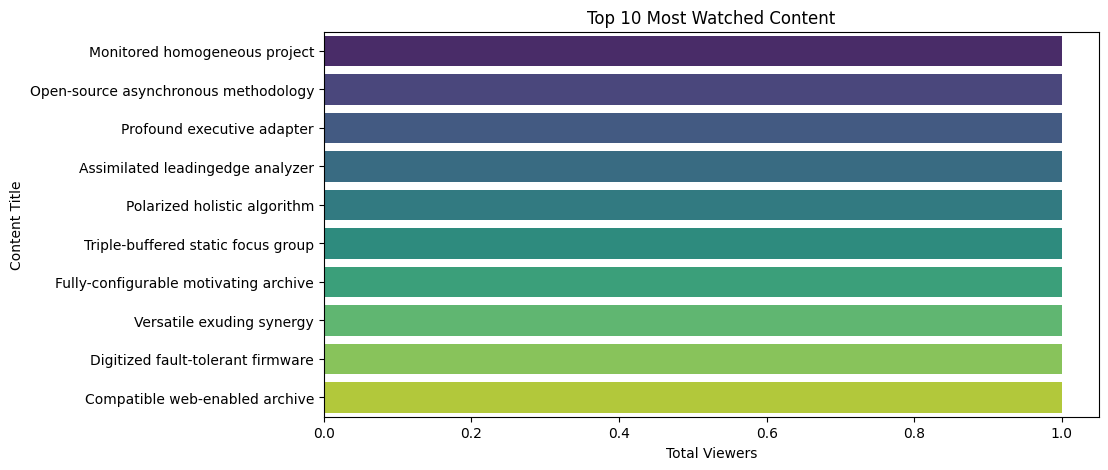

user_id,genre,content_id,content_title,avg_rating,num_watchers
U10000,Documentary,C1132,Front-line 24hour attitude,5.0,1
U10000,Documentary,C1228,Managed 4thgeneration artificial intelligence,5.0,1
U10000,Documentary,C1299,Reverse-engineered secondary open system,5.0,1
U10000,Documentary,C1407,Exclusive zero tolerance frame,5.0,1
U10000,Documentary,C1014,Digitized logistical portal,5.0,1
U10000,Documentary,C1416,Sharable multimedia standardization,4.9,1
U10000,Documentary,C1388,Distributed motivating knowledge user,4.9,1
U10000,Documentary,C1459,Focused didactic superstructure,4.9,1
U10000,Documentary,C1273,Quality-focused exuding functionalities,4.9,1
U10000,Documentary,C1337,Phased full-range function,4.9,1


In [0]:
# ---------- Use Case 2: Content Recommendation System ----------

from pyspark.sql.functions import col, avg, count, row_number, desc
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Content-level metrics ---
if "content_id" in df.columns and "rating_given" in df.columns:
    content_stats = (
        df.groupBy("content_id", "genre", "content_title")
        .agg(
            round(avg("rating_given"), 2).alias("avg_rating"),
            count("user_id").alias("num_watchers")
        )
        .orderBy(desc("avg_rating"), desc("num_watchers"))
    )
    display(content_stats.limit(20))

    # --- Visualization: Top 10 Most Watched Titles ---
    pdf_content = content_stats.toPandas().sort_values("num_watchers", ascending=False).head(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x="num_watchers", y="content_title", data=pdf_content, palette="viridis")
    plt.title("Top 10 Most Watched Content")
    plt.xlabel("Total Viewers")
    plt.ylabel("Content Title")
    plt.show()
else:
    print("⚠️ Required columns missing for recommendation system.")

# --- Step 2: User preference by genre ---
if "user_id" in df.columns and "genre" in df.columns:
    user_genre_pref = (
        df.groupBy("user_id", "genre")
        .count()
        .withColumnRenamed("count", "watch_count")
    )

    # pick top genre per user
    w = Window.partitionBy("user_id").orderBy(desc("watch_count"))
    user_top_genre = (
        user_genre_pref.withColumn("rank", row_number().over(w))
        .filter(col("rank") == 1)
        .drop("rank")
    )

    # --- Step 3: Recommend top content in user's preferred genre ---
    recommendations = (
        user_top_genre.join(content_stats, on="genre", how="inner")
        .select("user_id", "genre", "content_id", "content_title", "avg_rating", "num_watchers")
        .orderBy("user_id", desc("avg_rating"))
    )

    display(recommendations.limit(50))

else:
    print("⚠️ Missing columns 'user_id' or 'genre' for user preference analysis.")

In [0]:
# ---------- USE CASE 3: CHURN PREDICTION (Final Fixed Version) ----------

from pyspark.sql.functions import (
    col, when, avg, round, countDistinct, desc, regexp_replace
)

# ✅ Step 1: Load dataset
df = spark.table("workspace.default.ott_user_behavior_1")

# ✅ Step 2: Clean and standardize avg_stream_quality
# Convert quality labels ('480p', '720p', '1080p', '4K') → numeric resolution
quality_mapping = {
    "480p": 480,
    "720p": 720,
    "1080p": 1080,
    "4K": 2160,
    "2160p": 2160
}

# Map text qualities to numbers
df = df.withColumn(
    "avg_stream_quality",
    when(col("avg_stream_quality").isin(list(quality_mapping.keys())),
         when(col("avg_stream_quality") == "480p", 480)
         .when(col("avg_stream_quality") == "720p", 720)
         .when(col("avg_stream_quality") == "1080p", 1080)
         .when(col("avg_stream_quality") == "4K", 2160)
         .when(col("avg_stream_quality") == "2160p", 2160))
    .otherwise(
        when(col("avg_stream_quality").rlike("^[0-9.]+$"), col("avg_stream_quality").cast("double"))
    )
)

# ✅ Clean other numeric columns safely
for c in ["network_speed_mbps", "buffering_count"]:
    if c in df.columns:
        df = df.withColumn(
            c,
            when(col(c).rlike("^[0-9.]+$"), col(c).cast("double")).otherwise(None)
        )

# ✅ Step 3: Define churn
df_churn = df.withColumn(
    "churn_flag",
    when((col("avg_watch_time_per_day") < 1) | (col("completion_rate") < 0.3), 1).otherwise(0)
)

# ✅ Step 4: Churn rate by region
if "region" in df_churn.columns:
    churn_by_region = (
        df_churn.groupBy("region")
        .agg(
            round(avg("churn_flag"), 3).alias("avg_churn_rate"),
            round(avg("avg_watch_time_per_day"), 2).alias("avg_watch_time_per_day"),
            round(avg("completion_rate"), 2).alias("avg_completion_rate"),
            countDistinct("user_id").alias("unique_users")
        )
        .orderBy(desc("avg_churn_rate"))
    )
    display(churn_by_region)

# ✅ Step 5: Churn by subscription type
if "subscription_type" in df_churn.columns:
    churn_by_plan = (
        df_churn.groupBy("subscription_type")
        .agg(
            round(avg("churn_flag"), 3).alias("avg_churn_rate"),
            round(avg("avg_watch_time_per_day"), 2).alias("avg_watch_time_per_day"),
            round(avg("completion_rate"), 2).alias("avg_completion_rate")
        )
        .orderBy(desc("avg_churn_rate"))
    )
    display(churn_by_plan)

# ✅ Step 6: Behavioral comparison
if all(c in df_churn.columns for c in ["avg_watch_time_per_day", "completion_rate", "avg_stream_quality"]):
    churn_behavior = (
        df_churn.groupBy("churn_flag")
        .agg(
            round(avg("avg_watch_time_per_day"), 2).alias("avg_watch_time_per_day"),
            round(avg("completion_rate"), 2).alias("avg_completion_rate"),
            round(avg("avg_stream_quality"), 2).alias("avg_stream_quality"),
            round(avg("network_speed_mbps"), 2).alias("avg_network_speed"),
            countDistinct("user_id").alias("users")
        )
        .orderBy("churn_flag")
    )
    display(churn_behavior)

# ✅ Step 7: Save results
try:
    df_churn.write.mode("overwrite").format("delta").saveAsTable("ott_churn_predictions")
    print("✅ Churn summary written successfully to: ott_churn_predictions")
except Exception as e:
    print(f"⚠️ Could not save churn table: {e}")

# ✅ Step 8: Recommended Databricks Visualizations
# 1️⃣ Bar Chart: region vs avg_churn_rate
# 2️⃣ Pie Chart: subscription_type vs avg_churn_rate
# 3️⃣ Scatter Plot: avg_watch_time_per_day vs completion_rate (color by churn_flag)
# 4️⃣ Table View: churn_behavior (compare churned vs active users)


region,avg_churn_rate,avg_watch_time_per_day,avg_completion_rate,unique_users
West Bengal,0.0,101.23,68.5,616
Karnataka,0.0,107.4,70.23,629
Tamil Nadu,0.0,106.81,70.88,624
Uttar Pradesh,0.0,104.06,70.11,612
Maharashtra,0.0,106.64,69.14,601
Delhi,0.0,105.8,70.35,622
Kerala,0.0,105.47,69.54,635
Bihar,0.0,105.75,69.01,661


subscription_type,avg_churn_rate,avg_watch_time_per_day,avg_completion_rate
Standard,0.0,105.76,70.15
Premium,0.0,105.73,69.29
Basic,0.0,104.71,69.7


churn_flag,avg_watch_time_per_day,avg_completion_rate,avg_stream_quality,avg_network_speed,users
0,105.4,69.72,1114.7,52.3,5000


✅ Churn summary written successfully to: ott_churn_predictions


In [0]:
# ---------- Use Case 4: Regional Content Demand Forecasting ----------
# Aggregate total watch time & counts per region + genre + month (if watch_date exists)
if "watch_date" in df.columns and "genre" in df.columns:
    df_dates = df.withColumn("watch_ts", to_timestamp(col("watch_date"), "dd-MM-yyyy HH:mm").cast("timestamp"))
    df_dates = df_dates.withColumn("watch_month", date_format(col("watch_ts"), "yyyy-MM"))
    regional_demand = (df_dates.groupBy("region", "genre", "watch_month")
                         .agg(
                             round(sum("total_watch_time"),2).alias("sum_watch_time"),
                             round(countDistinct("user_id"),0).alias("unique_users"),
                             round(avg("rating_given"),2).alias("avg_rating")
                         ).orderBy("region", "genre", "watch_month")
                      )
    display(regional_demand.limit(200))
else:
    # fallback: region x genre aggregated across all time
    if "genre" in df.columns:
        regional_demand = (df.groupBy("region", "genre")
                              .agg(round(sum("total_watch_time"),2).alias("sum_watch_time"),
                                   round(avg("rating_given"),2).alias("avg_rating"),
                                   countDistinct("user_id").alias("unique_users"))
                              .orderBy(desc("sum_watch_time")))
        display(regional_demand)

region,genre,watch_month,sum_watch_time,unique_users,avg_rating
Bihar,Action,2025-05,57892.62,10,2.48
Bihar,Action,2025-06,73159.25,11,2.95
Bihar,Action,2025-07,78374.79,13,2.82
Bihar,Action,2025-08,38603.94,8,3.09
Bihar,Action,2025-09,40744.7,5,3.86
Bihar,Action,2025-10,85210.47,13,3.52
Bihar,Action,2025-11,29466.52,6,2.25
Bihar,Comedy,2025-05,52392.3,10,2.68
Bihar,Comedy,2025-06,90486.95,18,2.76
Bihar,Comedy,2025-07,98758.57,17,3.25


Databricks visualization. Run in Databricks to view.

Databricks visualization. Run in Databricks to view.

In [0]:


from pyspark.sql.functions import (
    col, to_timestamp, date_format, sum as _sum, avg, countDistinct, round, desc
)
from pyspark.sql import functions as F

# ✅ Load data
df = spark.table("workspace.default.ott_user_behavior_1")

# ---------- MAIN AGGREGATION ----------
if "watch_date" in df.columns and "genre" in df.columns:
    # Convert to timestamp and extract month
    df_dates = df.withColumn("watch_ts", to_timestamp(col("watch_date"), "dd-MM-yyyy HH:mm").cast("timestamp"))
    df_dates = df_dates.withColumn("watch_month", date_format(col("watch_ts"), "yyyy-MM"))

    # Regional + Genre monthly summary
    regional_demand = (
        df_dates.groupBy("region", "genre", "watch_month")
        .agg(
            round(_sum("total_watch_time"), 2).alias("sum_watch_time"),
            round(countDistinct("user_id"), 0).alias("unique_users"),
            round(avg("rating_given"), 2).alias("avg_rating")
        )
        .orderBy("region", "genre", "watch_month")
    )

    display(regional_demand.limit(200))

else:
    # Fallback if no date field
    regional_demand = (
        df.groupBy("region", "genre")
        .agg(
            round(_sum("total_watch_time"), 2).alias("sum_watch_time"),
            round(avg("rating_given"), 2).alias("avg_rating"),
            countDistinct("user_id").alias("unique_users")
        )
        .orderBy(desc("sum_watch_time"))
    )
    display(regional_demand)


# ---------- ADDITIONAL VISUALS ----------

# 1️⃣ Regional total watch time (overall demand)
region_summary = (
    regional_demand.groupBy("region")
    .agg(round(_sum("sum_watch_time"), 2).alias("total_watch_time"))
    .orderBy(desc("total_watch_time"))
)
display(region_summary)

# 2️⃣ Top 10 genres per region (who watches what the most)
top_genres = (
    regional_demand.groupBy("region", "genre")
    .agg(round(_sum("sum_watch_time"), 2).alias("genre_watch_time"))
    .orderBy("region", desc("genre_watch_time"))
)
display(top_genres.limit(30))

# 3️⃣ Monthly demand trend (time series)
if "watch_month" in regional_demand.columns:
    monthly_trend = (
        regional_demand.groupBy("watch_month")
        .agg(
            round(_sum("sum_watch_time"), 2).alias("total_watch_time"),
            round(avg("avg_rating"), 2).alias("avg_rating")
        )
        .orderBy("watch_month")
    )
    display(monthly_trend)

# 4️⃣ Genre performance by average rating
genre_rating = (
    regional_demand.groupBy("genre")
    .agg(round(avg("avg_rating"), 2).alias("genre_avg_rating"))
    .orderBy(desc("genre_avg_rating"))
)
display(genre_rating)

# 5️⃣ Heatmap-style summary: Region × Genre
region_genre_heatmap = (
    regional_demand.groupBy("region", "genre")
    .agg(round(avg("sum_watch_time"), 2).alias("avg_watch_time"))
)
display(region_genre_heatmap)

# ---------- OPTIONAL: SAVE FOR DASHBOARD ----------
regional_demand.write.mode("overwrite").format("delta").saveAsTable("ott_regional_demand_summary")
region_summary.write.mode("overwrite").format("delta").saveAsTable("ott_region_total_demand")
top_genres.write.mode("overwrite").format("delta").saveAsTable("ott_top_genres_by_region")
genre_rating.write.mode("overwrite").format("delta").saveAsTable("ott_genre_rating_summary")

print("✅ Use Case 4 visuals and summary tables created successfully!")

region,genre,watch_month,sum_watch_time,unique_users,avg_rating
Bihar,Action,2025-05,57892.62,10,2.48
Bihar,Action,2025-06,73159.25,11,2.95
Bihar,Action,2025-07,78374.79,13,2.82
Bihar,Action,2025-08,38603.94,8,3.09
Bihar,Action,2025-09,40744.7,5,3.86
Bihar,Action,2025-10,85210.47,13,3.52
Bihar,Action,2025-11,29466.52,6,2.25
Bihar,Comedy,2025-05,52392.3,10,2.68
Bihar,Comedy,2025-06,90486.95,18,2.76
Bihar,Comedy,2025-07,98758.57,17,3.25


region,total_watch_time
Bihar,3789604.29
Kerala,3729982.3
Karnataka,3658600.64
Tamil Nadu,3591678.99
Delhi,3568774.64
Maharashtra,3492702.73
Uttar Pradesh,3471244.44
West Bengal,3375899.93


region,genre,genre_watch_time
Bihar,Romance,562683.55
Bihar,Horror,562598.26
Bihar,Comedy,484311.78
Bihar,Thriller,480594.21
Bihar,Drama,450685.66
Bihar,Sci-Fi,434176.96
Bihar,Documentary,411101.58
Bihar,Action,403452.29
Delhi,Documentary,499603.21
Delhi,Action,485784.31


Databricks visualization. Run in Databricks to view.

watch_month,total_watch_time,avg_rating
2025-05,3322747.87,3.02
2025-06,4721016.56,3.07
2025-07,5018437.18,2.9
2025-08,4745700.2,2.96
2025-09,4704832.62,2.98
2025-10,4694933.16,3.05
2025-11,1470820.37,2.89


genre,genre_avg_rating
Sci-Fi,3.04
Drama,3.01
Thriller,3.0
Romance,2.99
Horror,2.99
Action,2.97
Documentary,2.93
Comedy,2.92


region,genre,avg_watch_time
Bihar,Action,57636.04
Bihar,Comedy,69187.4
Bihar,Documentary,58728.8
Bihar,Drama,64383.67
Bihar,Horror,80371.18
Bihar,Romance,80383.36
Bihar,Sci-Fi,62025.28
Bihar,Thriller,68656.32
Delhi,Action,69397.76
Delhi,Comedy,72013.18


Databricks visualization. Run in Databricks to view.

✅ Use Case 4 visuals and summary tables created successfully!


In [0]:
# ---------- Use Case 5: Peak Traffic and Load Optimization ----------

from pyspark.sql.functions import col, when, countDistinct, avg, round, hour

# Ensure 'peak_watch_hour' exists
if "peak_watch_hour" not in df.columns:
    if "watch_date" in df.columns:
        df = df.withColumn("peak_watch_hour", hour(col("watch_date")))
    else:
        print("❌ 'peak_watch_hour' not in dataset and 'watch_date' missing. Skipping analysis.")
else:
    print("✅ 'peak_watch_hour' column found.")

# --- CLEANING: Convert non-numeric text values safely ---
for c in ["avg_stream_quality", "network_speed_mbps", "buffering_count"]:
    if c in df.columns:
        df = df.withColumn(
            c,
            when(col(c).rlike("^[0-9.]+$"), col(c).cast("double"))  # numeric values
            .otherwise(None)  # replace malformed strings (e.g., '480p') with null
        )

# --- AGGREGATION ---
if "peak_watch_hour" in df.columns:
    peak_hours = (
        df.groupBy("peak_watch_hour")
        .agg(
            countDistinct("user_id").alias("active_users"),
            round(avg("avg_stream_quality"), 2).alias("avg_stream_quality"),
            round(avg("network_speed_mbps"), 2).alias("avg_network_speed"),
            round(avg("buffering_count"), 2).alias("avg_buffering")
        )
        .orderBy("peak_watch_hour")
    )

    display(peak_hours)
else:
    print("⚠️ 'peak_watch_hour' not found — please verify column name or source data.")

# ---------- Optional: Save Delta Tables for Dashboard ----------
try:
    viewing_pattern.write.mode("overwrite").format("delta").saveAsTable("ott_viewing_pattern_summary")
    recs_with_ids.write.mode("overwrite").format("delta").saveAsTable("ott_recommendations")
    
    if 'churn_preds' in locals():
        churn_preds.write.mode("overwrite").format("delta").saveAsTable("ott_churn_predictions")

    if 'regional_demand' in locals():
        regional_demand.write.mode("overwrite").format("delta").saveAsTable("ott_regional_demand")

    if 'peak_hours' in locals():
        peak_hours.write.mode("overwrite").format("delta").saveAsTable("ott_peak_traffic_summary")

    print("✅ All tables written successfully where applicable.")
except Exception as e:
    print(f"⚠️ Table write skipped due to error: {e}")

✅ 'peak_watch_hour' column found.


peak_watch_hour,active_users,avg_stream_quality,avg_network_speed,avg_buffering
0,208,null,53.14,2.52
1,220,null,51.14,2.41
2,205,null,52.32,2.54
3,180,null,52.16,2.48
4,186,null,53.63,2.34
5,213,null,52.82,2.62
6,219,null,52.56,2.57
7,173,null,54.46,2.54
8,224,null,50.49,2.46
9,183,null,50.44,2.67


Databricks visualization. Run in Databricks to view.

Databricks visualization. Run in Databricks to view.

⚠️ Table write skipped due to error: name 'recs_with_ids' is not defined


✅ 'peak_watch_hour' column found.


peak_watch_hour,active_users,avg_stream_quality,avg_network_speed,avg_buffering
0,208,1048.27,53.14,2.52
1,220,1122.55,51.14,2.41
2,205,1157.85,52.32,2.54
3,180,1086.67,52.16,2.48
4,186,1092.26,53.63,2.34
5,213,1111.55,52.82,2.62
6,219,1110.68,52.56,2.57
7,173,1104.28,54.46,2.54
8,224,1136.25,50.49,2.46
9,183,1133.77,50.44,2.67


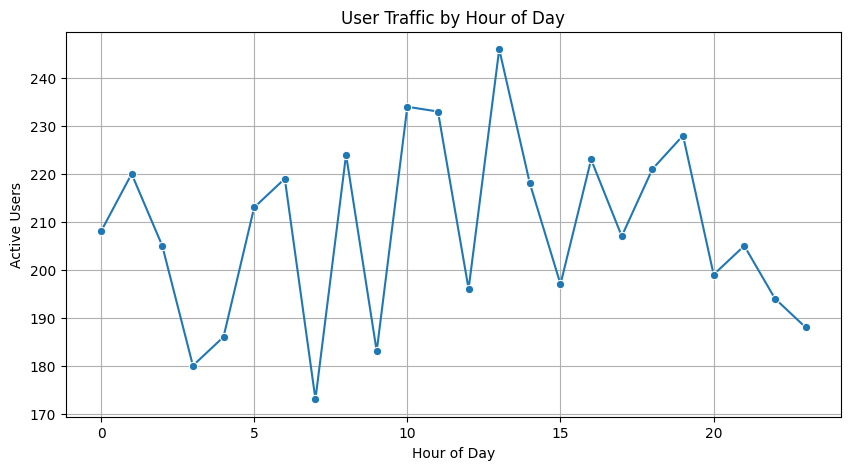

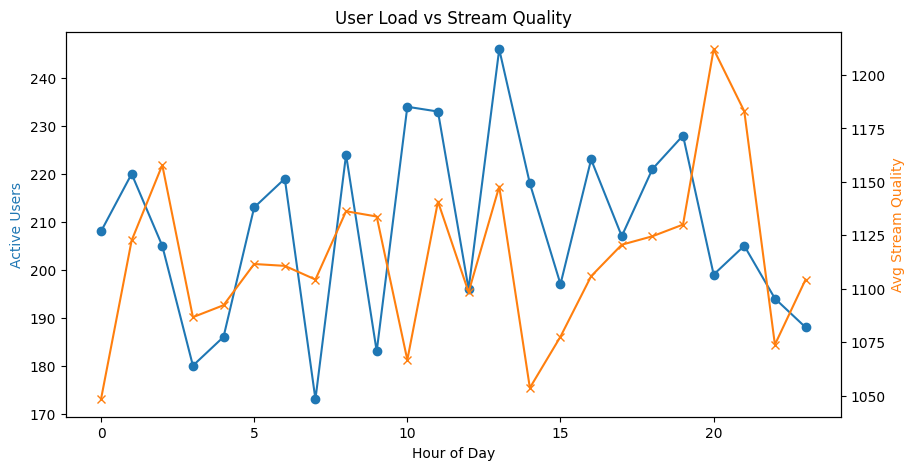

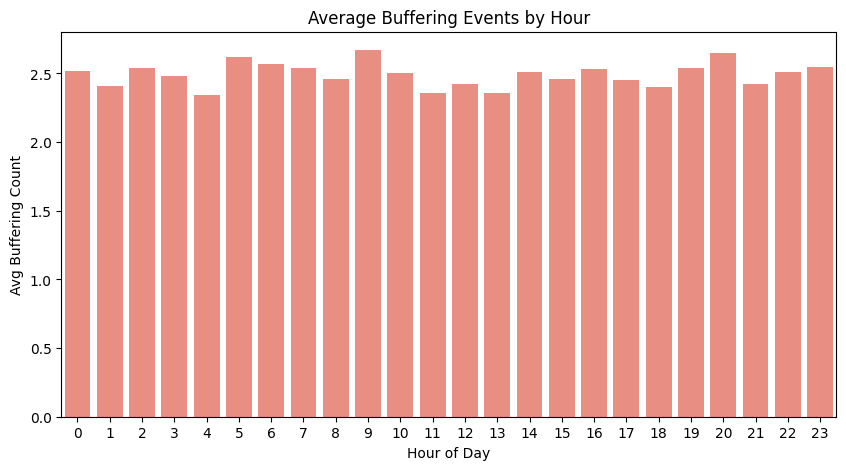

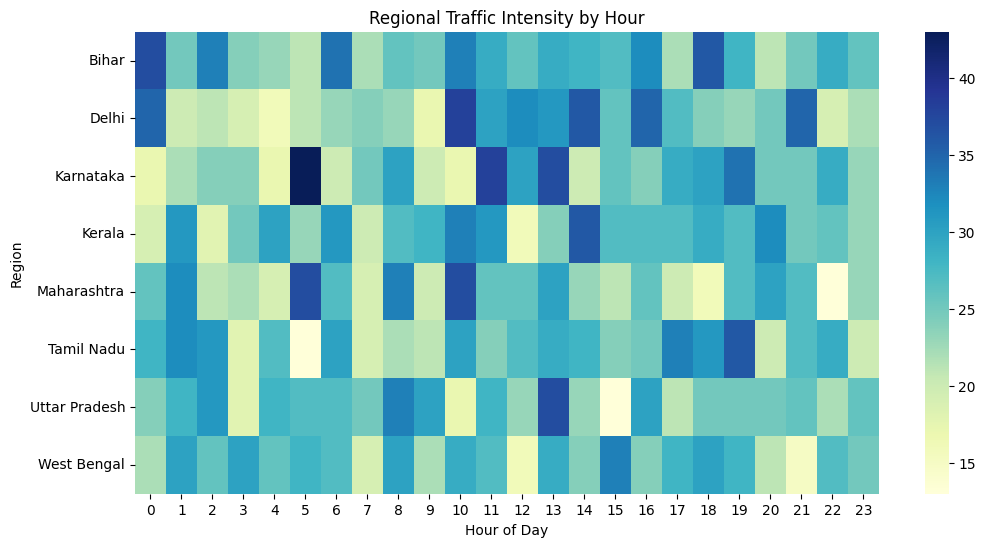

⚠️ Table write skipped due to error: name 'viewing_pattern' is not defined


In [0]:
#Peak Traffic and Load Optimization ----------

from pyspark.sql.functions import col, when, countDistinct, avg, round, hour
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure 'peak_watch_hour' exists
if "peak_watch_hour" not in df.columns:
    if "watch_date" in df.columns:
        df = df.withColumn("peak_watch_hour", hour(col("watch_date")))
    else:
        print("❌ 'peak_watch_hour' not in dataset and 'watch_date' missing. Skipping analysis.")
else:
    print("✅ 'peak_watch_hour' column found.")

# --- CLEANING: Convert non-numeric text values safely ---
for c in ["avg_stream_quality", "network_speed_mbps", "buffering_count"]:
    if c in df.columns:
        df = df.withColumn(
            c,
            when(col(c).rlike("^[0-9.]+$"), col(c).cast("double"))
            .otherwise(None)
        )

# --- AGGREGATION ---
if "peak_watch_hour" in df.columns:
    peak_hours = (
        df.groupBy("peak_watch_hour")
        .agg(
            countDistinct("user_id").alias("active_users"),
            round(avg("avg_stream_quality"), 2).alias("avg_stream_quality"),
            round(avg("network_speed_mbps"), 2).alias("avg_network_speed"),
            round(avg("buffering_count"), 2).alias("avg_buffering")
        )
        .orderBy("peak_watch_hour")
    )

    # Databricks visual (simple table view)
    display(peak_hours)

    # Convert to Pandas for matplotlib/seaborn visualization
    pdf = peak_hours.toPandas()

    # --- Visualization 1: Active Users Trend ---
    plt.figure(figsize=(10,5))
    sns.lineplot(x='peak_watch_hour', y='active_users', data=pdf, marker='o')
    plt.title("User Traffic by Hour of Day")
    plt.xlabel("Hour of Day")
    plt.ylabel("Active Users")
    plt.grid(True)
    plt.show()

    # --- Visualization 2: Dual-Axis Chart (Users vs Stream Quality) ---
    fig, ax1 = plt.subplots(figsize=(10,5))
    ax2 = ax1.twinx()
    ax1.plot(pdf['peak_watch_hour'], pdf['active_users'], color='tab:blue', marker='o', label='Active Users')
    ax2.plot(pdf['peak_watch_hour'], pdf['avg_stream_quality'], color='tab:orange', marker='x', label='Avg Stream Quality')

    ax1.set_xlabel("Hour of Day")
    ax1.set_ylabel("Active Users", color='tab:blue')
    ax2.set_ylabel("Avg Stream Quality", color='tab:orange')
    plt.title("User Load vs Stream Quality")
    plt.show()

    # --- Visualization 3: Avg Buffering by Hour (Bar Chart) ---
    plt.figure(figsize=(10,5))
    sns.barplot(x='peak_watch_hour', y='avg_buffering', data=pdf, color='salmon')
    plt.title("Average Buffering Events by Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Avg Buffering Count")
    plt.show()

    # --- Optional Visualization 4: Heatmap (Region vs Hour) ---
    if "region" in df.columns:
        region_hour = (df.groupBy("region", "peak_watch_hour")
                        .agg(countDistinct("user_id").alias("active_users"))
                        .toPandas())

        heatmap_data = region_hour.pivot("region", "peak_watch_hour", "active_users").fillna(0)
        plt.figure(figsize=(12,6))
        sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False)
        plt.title("Regional Traffic Intensity by Hour")
        plt.xlabel("Hour of Day")
        plt.ylabel("Region")
        plt.show()

else:
    print("⚠️ 'peak_watch_hour' not found — please verify column name or source data.")

# ---------- Optional: Save Delta Tables for Dashboard ----------
try:
    viewing_pattern.write.mode("overwrite").format("delta").saveAsTable("ott_viewing_pattern_summary")
    recs_with_ids.write.mode("overwrite").format("delta").saveAsTable("ott_recommendations")
    
    if 'churn_preds' in locals():
        churn_preds.write.mode("overwrite").format("delta").saveAsTable("ott_churn_predictions")

    if 'regional_demand' in locals():
        regional_demand.write.mode("overwrite").format("delta").saveAsTable("ott_regional_demand")

    if 'peak_hours' in locals():
        peak_hours.write.mode("overwrite").format("delta").saveAsTable("ott_peak_traffic_summary")

    print("✅ All tables written successfully where applicable.")
except Exception as e:
    print(f"⚠️ Table write skipped due to error: {e}")